In [84]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

import stencil
import diffusion

In [41]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

In [78]:
def relaxJ(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 2.0 / 3.0
    
    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)

    return unew

def relax(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    DE = sparse.tril(A, 0).tocsc()
    
    for i in range(nu):
        unew += sla.spsolve(DE, f - A * unew, permc_spec='NATURAL')

    return unew

def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc))
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def create_operator(n, sten):
    """
    Create a 2D operator from a stencil.
    """
    A = stencil.stencil_grid(sten, (n, n), format='csr')
    return A

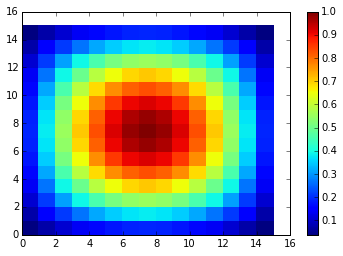

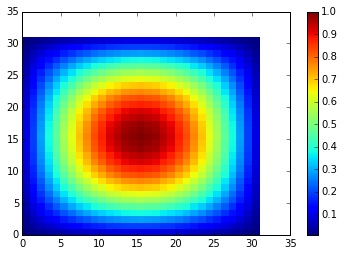

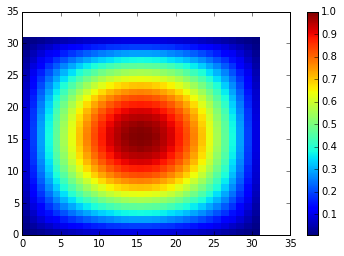

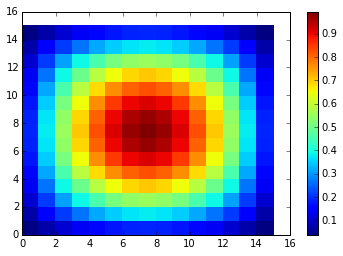

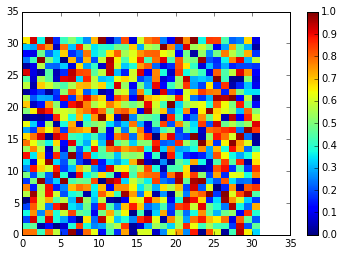

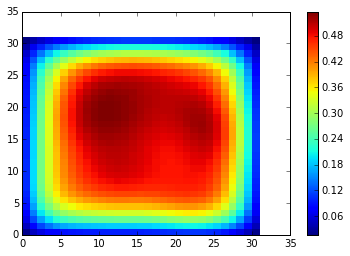

In [79]:
n = 2**5 - 1
nc = 2**4 - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = create_operator(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
P.toarray()

x1d = np.linspace(0, 1, nc+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
uc = np.sin(np.pi * X) * np.sin(np.pi * Y)
plt.figure()
plt.pcolormesh(uc)
plt.colorbar()

u = P * uc.ravel()
u = u.reshape((n,n))
plt.figure()
plt.pcolormesh(u)
plt.colorbar()

x1d = np.linspace(0, 1, n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
u = np.sin(np.pi * X) * np.sin(np.pi * Y)
plt.figure()
plt.pcolormesh(u)
plt.colorbar()

uc = 0.25 * P.T * u.ravel()
uc = uc.reshape((nc,nc))
plt.figure()
plt.pcolormesh(uc)
plt.colorbar()

u = np.random.rand(n*n)
f = np.zeros((n*n,))
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()
u = relax(A, u, f, 15)
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()

In [80]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = create_operator(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
u0 = np.random.rand(n*n)
f0 = np.zeros((n*n,))
print(hnorm(f0 - A * u0))

u0 = relax(A, u0, f0, 1)
f1 = P.T * (f0 - A * u0)

A1 = P.T * A * P
u1 = sla.spsolve(A1, f1)

u0 = u0 + P * u1
u0 = relax(A, u0, f0, 1)
print(hnorm(f0 - A * u0))

u0 = relax(A, u0, f0, 1)
f1 = P.T * (f0 - A * u0)

A1 = P.T * A * P
u1 = sla.spsolve(A1, f1)

u0 = u0 + P * u1
u0 = relax(A, u0, f0, 1)
print(hnorm(f0 - A * u0))

0.0417679576074
0.00383215934021
0.000431533657262


In [106]:
def twogrid(A, P, A1, u0, f0, nu):
    u0 = relax(A, u0, f0, nu)
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    u0 = relax(A, u0, f0, nu)
    return u0

In [107]:
k = 8
n = 2**k - 1
nc = 2**(k-1) - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = (n+1)**2 * create_operator(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
u = np.random.rand(n*n)
f = np.zeros((n*n,))

A1 = P.T * A * P
res = [hnorm(f - A * u)]
for i in range(10):
    u = twogrid(A, P, A1, u, f, 1)
    res.append(hnorm(f - A * u))
    
res = np.array(res)
print(res[1:] / res[:-1])

[ 0.09240313  0.11435013  0.11583725  0.12043418  0.13144935  0.12922667
  0.12481898  0.13509674  0.13975185  0.13044278]


In [114]:
k = 6
n = 2**k - 1
nc = 2**(k-1) - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = (n+1)**2 * create_operator(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()

x1d = np.linspace(0, 1, n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
ustar = (X**2 - X**4) * (Y**4 - Y**2)
f = 2 * ((1-6*X**2) * Y**2 * (1 - Y**2)) + ((1-6*Y**2) * X**2 * (1-X**2))
f = f.ravel()
u = np.random.rand(n*n)

A1 = P.T * A * P
res = [hnorm(f - A * u)]
err = [hnorm(ustar.ravel() - u)]
for i in range(10):
    u = twogrid(A, P, A1, u, f, 2)
    res.append(hnorm(f - A * u))
    err.append(hnorm(ustar.ravel() - u))

res = np.array(res)
print(res[1:] / res[:-1])

[ 0.01253381  0.02170386  0.03104807  0.03480697  0.03865022  0.04141722
  0.04365461  0.04548537  0.04661895  0.04740987]


In [115]:
print(["%e" % e for e in err])

['9.425084e-03', '1.685321e-04', '1.084528e-04', '1.083310e-04', '1.083297e-04', '1.083296e-04', '1.083296e-04', '1.083296e-04', '1.083296e-04', '1.083296e-04', '1.083296e-04']


In [128]:
k = 8
n = 2**k - 1
nc = 2**(k-1) - 1
sten = diffusion.diffusion_stencil_2d(epsilon=0.000001, theta=np.pi/4, type='FD')
A = (n+1)**2 * create_operator(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()

x1d = np.linspace(0, 1, n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
ustar = (X**2 - X**4) * (Y**4 - Y**2)
f = 2 * ((1-6*X**2) * Y**2 * (1 - Y**2)) + ((1-6*Y**2) * X**2 * (1-X**2))
f = f.ravel()
u = np.random.rand(n*n)

A1 = P.T * A * P
res = [hnorm(f - A * u)]
err = [hnorm(ustar.ravel() - u)]
for i in range(10):
    u = twogrid(A, P, A1, u, f, 2)
    res.append(hnorm(f - A * u))
    err.append(hnorm(ustar.ravel() - u))

res = np.array(res)
print(res[1:] / res[:-1])

[ 0.01762208  0.13337125  0.28414191  0.35608162  0.39780537  0.42440304
  0.44247351  0.45539941  0.46506313  0.47256727]


In [129]:
sten = diffusion.diffusion_stencil_2d

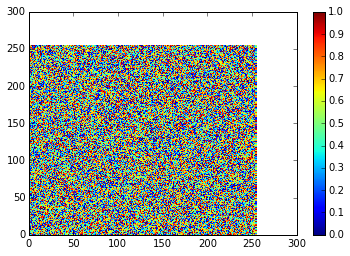

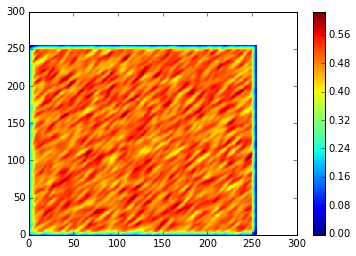

In [130]:
u = np.random.rand(n*n)
f = np.zeros((n*n,))
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()
u = relax(A, u, f, 15)
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()

In [133]:
P = interpolation1d(2**3-1, 2**4-1)
P.toarray()

array([[ 0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.5,  0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.5,  0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5]])